# Complete End-to-End SAR Processing Example

This notebook demonstrates all SAR processing modules working together:
- Configuration
- STAC data search
- Data loading with preprocessing
- Change detection
- Statistical analysis
- Visualization
- Batch processing

## 1. Import All Modules

In [1]:
# Import SAR processing modules
from sar_processing import (
    STACClient,
    SARDataLoader,
    ChangeDetector,
    SARStatistics,
    SARVisualizer,
    BatchProcessor,
)
from sar_processing.config import (
    STACConfig,
    ProcessingConfig,
    VisualizationConfig,
)
from sar_processing.batch_processor import ProcessingTask

# Import standard libraries
import matplotlib.pyplot as plt
import numpy as np

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


## 2. Configure the System

Set up configurations for STAC search, data processing, and visualization.

In [2]:
# STAC search configuration
stac_config = STACConfig(
    orbit_state="ascending",
    instrument_mode="IW",
    limit=10  # Limit for testing
)

# Data processing configuration
processing_config = ProcessingConfig(
    bands=["vv", "vh"],
    chunk_size=(512, 512),
    resolution=20,  # 20m resolution
    crs="EPSG:3067"  # ETRS-TM35FIN (Finland)
)

# Visualization configuration
vis_config = VisualizationConfig(
    db_min=-25,
    db_max=5,
    change_min=-5,
    change_max=5,
    figsize=(18, 5)
)

print("✅ Configurations set up!")

✅ Configurations set up!


## 3. Initialize Modules

Create instances of all processing modules.

In [3]:
# Initialize modules with configurations
stac_client = STACClient(config=stac_config)
data_loader = SARDataLoader(config=processing_config)
change_detector = ChangeDetector()
statistics = SARStatistics()
visualizer = SARVisualizer(config=vis_config)
batch_processor = BatchProcessor(stac_client, data_loader)

print("✅ All modules initialized!")

✅ All modules initialized!


## 4. Search for SAR Data

Search for Sentinel-1 data over Helsinki area.

In [4]:
# Define area of interest (Helsinki)
helsinki_bbox = (24.8, 60.1, 25.2, 60.3)
date_range = "2022-01-01/2022-01-31"

# Search and sign items
print(f"Searching for Sentinel-1 data over Helsinki...")
items = stac_client.search_and_sign(
    bbox=helsinki_bbox,
    datetime=date_range,
    limit=10
)

print(f"✅ Found {len(items)} Sentinel-1 scenes")

if len(items) == 0:
    raise RuntimeError("No Sentinel-1 scenes found for the given bbox/date range")

# Display metadata
if len(items) > 0:
    print("\nFirst item details:")
    print(f"  ID: {items[0].id}")
    print(f"  Date: {items[0].datetime}")
    print(f"  Assets: {list(items[0].assets.keys())}")

Searching for Sentinel-1 data over Helsinki...
✅ Found 3 Sentinel-1 scenes

First item details:
  ID: S1A_IW_GRDH_1SDV_20220124T160515_20220124T160540_041605_04F2EE
  Date: 2022-01-24 16:05:28.467159+00:00
  Assets: ['vh', 'vv', 'thumbnail', 'safe-manifest', 'schema-noise-vh', 'schema-noise-vv', 'schema-product-vh', 'schema-product-vv', 'schema-calibration-vh', 'schema-calibration-vv', 'tilejson', 'rendered_preview']


## 5. Load and Preprocess Data

Load the data with optional speckle filtering and dB conversion.

In [5]:
# Load data from STAC items
print("Loading SAR data...")
dataset = data_loader.load(
    items=items,
    bbox=helsinki_bbox
)

print(f"✅ Data loaded: {dataset}")

# Extract VV polarization with preprocessing
vv_data = data_loader.get_polarization(
    dataset,
    polarization="vv",
    sort_by_time=True,
    speckle_filter=False,  # Set to True for speckle filtering (not lazy loading)
    to_db=False  # Keep in linear for now
)

print(f"\nVV data shape: {vv_data.shape}")
print(f"Time range: {vv_data.time.min().values} to {vv_data.time.max().values}")

Loading SAR data...
✅ Data loaded: <xarray.Dataset> Size: 32MB
Dimensions:      (y: 1148, x: 1143, time: 3)
Coordinates:
  * y            (y) float64 9kB 6.687e+06 6.687e+06 ... 6.664e+06 6.664e+06
  * x            (x) float64 9kB 3.777e+05 3.777e+05 ... 4.005e+05 4.005e+05
  * time         (time) datetime64[ns] 24B 2022-01-12T16:05:29.096893 ... 202...
    spatial_ref  int32 4B 3067
Data variables:
    vv           (time, y, x) float32 16MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    vh           (time, y, x) float32 16MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

VV data shape: (3, 1148, 1143)
Time range: 2022-01-12T16:05:29.096893000 to 2022-01-24T16:05:28.467159000


## 6. Temporal Statistics

Compute mean and standard deviation over time.

Computing temporal statistics...
[#                                       ] | 4% Completed | 1.04 s ms

c:\Users\ecre.sener\AppData\Local\miniconda3\envs\sar-project-del\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
c:\Users\ecre.sener\AppData\Local\miniconda3\envs\sar-project-del\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
c:\Users\ecre.sener\AppData\Local\miniconda3\envs\sar-project-del\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


[########################################] | 100% Completed | 47.59 s
[########################################] | 100% Completed | 40.94 ss

✅ Statistics computed
Mean backscatter range: 34.33 to 13399.67
Std range: 0.00 to 17978.49


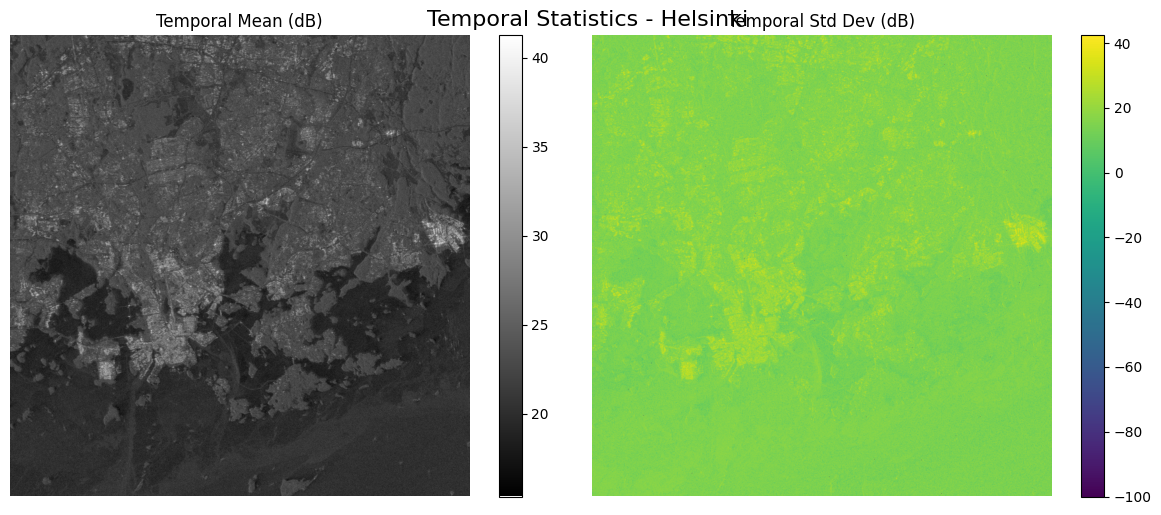

In [6]:
# Compute temporal statistics
if len(vv_data.time) > 0:
    print("Computing temporal statistics...")
    
    temporal_stats = statistics.temporal_stats(
        vv_data,
        compute=True,
        show_progress=True
    )
    
    mean_backscatter = temporal_stats["mean"]
    std_backscatter = temporal_stats["std"]
    
    print(f"\n✅ Statistics computed")
    print(f"Mean backscatter range: {float(mean_backscatter.min()):.2f} to {float(mean_backscatter.max()):.2f}")
    print(f"Std range: {float(std_backscatter.min()):.2f} to {float(std_backscatter.max()):.2f}")
    
    # Visualize temporal statistics
    fig, axes = visualizer.plot_temporal_stats(
        mean_backscatter,
        std_backscatter
    )
    plt.suptitle("Temporal Statistics - Helsinki", fontsize=16, y=1.02)
    plt.show()
else:
    print("⚠️ Not enough data for temporal statistics")

## 7. Change Detection

Detect changes between first and last image.

Performing change detection...

✅ Change detection completed
Change range: -17.93 to 21.18 dB

Change statistics:
  Mean: 0.11 dB
  Std: 2.05 dB


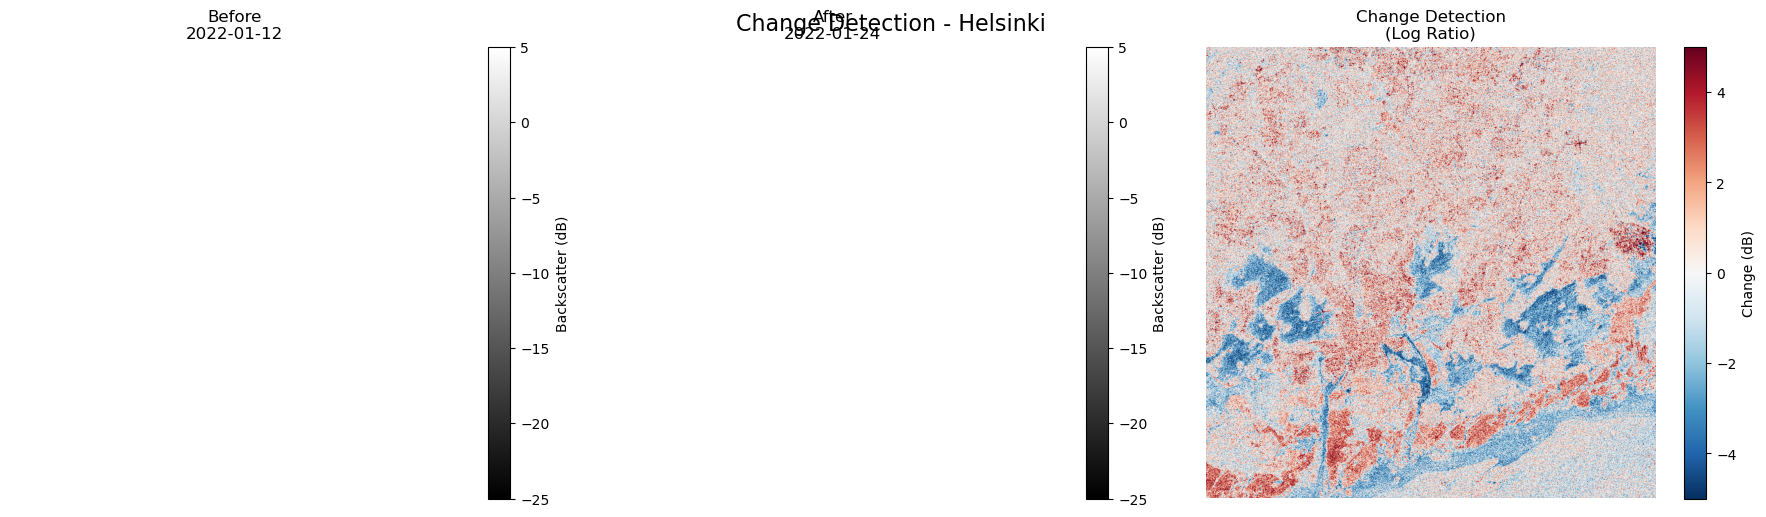

In [7]:
# Perform change detection
if len(vv_data.time) >= 2:
    print("Performing change detection...")
    
    # Get before and after images
    image_before = vv_data.isel(time=0)
    image_after = vv_data.isel(time=-1)
    
    # Compute log-ratio change
    change_map = change_detector.log_ratio(
        image_before,
        image_after,
        input_is_db=False  # Data is in linear scale
    )
    
    print(f"\n✅ Change detection completed")
    print(f"Change range: {float(change_map.min()):.2f} to {float(change_map.max()):.2f} dB")
    
    # Compute spatial statistics of change
    change_stats = statistics.spatial_stats(change_map, compute=True)
    print(f"\nChange statistics:")
    print(f"  Mean: {change_stats['mean']:.2f} dB")
    print(f"  Std: {change_stats['std']:.2f} dB")
    
    # Visualize change detection
    fig, axes = visualizer.plot_change_detection(
        image_before,
        image_after,
        change_map
    )
    plt.suptitle("Change Detection - Helsinki", fontsize=16, y=1.02)
    plt.show()
else:
    print("⚠️ Need at least 2 images for change detection")

## 8. Batch Processing Multiple Regions

Process multiple cities simultaneously.

In [ ]:
# Define multiple regions to process
cities = {
    "tampere": (23.7, 61.4, 24.0, 61.6),
    "turku": (22.1, 60.3, 22.5, 60.5),
    "helsinki": (24.8, 60.1, 25.2, 60.3),
}

print("Processing multiple cities...\n")

# Process all cities
results = batch_processor.process_multiple_regions(
    regions=cities,
    datetime="2022-01-01/2022-03-30",
    polarization="vv",
    compute_stats=True,
    compute_change=True,
    parallel=False  # Enable parallel processing with Dask

)

# Summarize results
print("\n" + "="*60)
print("BATCH PROCESSING RESULTS")
print("="*60)

for city, result in results.items():
    print(f"\n{city.upper()}:")
    
    if "error" in result:
        print(f"  ❌ {result['error']}")
        continue
    
    print(f"  ✅ Images found: {result['num_items']}")
    print(f"  Data shape: {result['shape']}")
    
    if "stats" in result:
        mean_val = float(result["stats"]["mean"].mean())
        std_val = float(result["stats"]["std"].mean())
        print(f"  Mean backscatter: {mean_val:.2f}")
        print(f"  Temporal variability: {std_val:.2f}")
    
    if "change" in result:
        change_mean = float(result["change"].mean())
        change_max = float(result["change"].max())
        print(f"  Mean change: {change_mean:.2f} dB")
        print(f"  Max change: {change_max:.2f} dB")

Processing multiple cities...



Processing turku:  33%|███▎      | 1/3 [01:56<03:53, 116.89s/it]  

## 9. Seasonal Analysis

Process the same region across different seasons.

Processing seasonal data for Helsinki...

Processing task: winter
  Found 12 items
  Computed statistics
Processing task: spring
  Found 13 items
  Computed statistics
Processing task: summer
  Found 13 items
  Computed statistics
Processing task: fall
  Found 15 items
  Computed statistics

SEASONAL ANALYSIS - HELSINKI

WINTER:
  ✅ Images: 12
  Mean backscatter: 178.47
  Temporal variability: 67.12

SPRING:
  ✅ Images: 13
  Mean backscatter: 183.35
  Temporal variability: 67.07

SUMMER:
  ✅ Images: 13
  Mean backscatter: 181.78
  Temporal variability: 63.58

FALL:
  ✅ Images: 15
  Mean backscatter: 177.59
  Temporal variability: 64.82


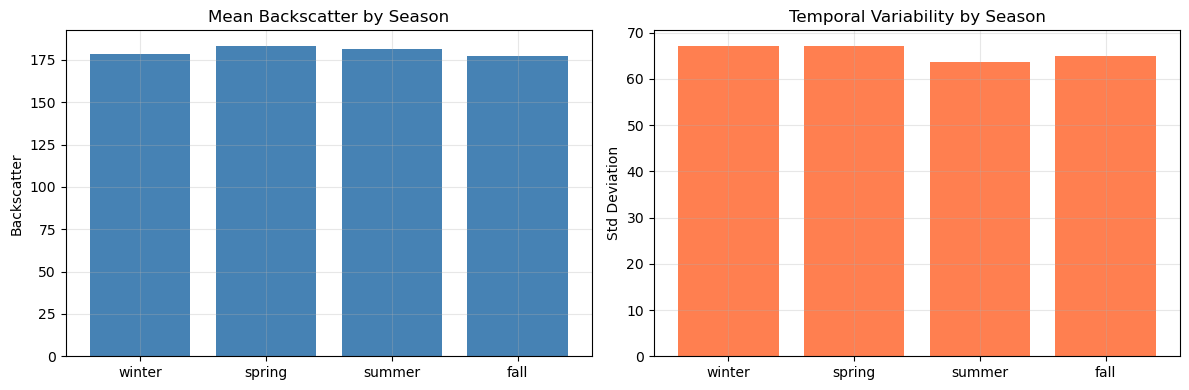

In [ ]:
# Define seasonal periods
seasons = {
    "winter": "2022-01-01/2022-03-31",
    "spring": "2022-04-01/2022-06-30",
    "summer": "2022-07-01/2022-09-30",
    "fall": "2022-10-01/2022-12-31",
}

print("Processing seasonal data for Helsinki...\n")

# Process all seasons
seasonal_results = batch_processor.process_multiple_periods(
    bbox=helsinki_bbox,
    periods=seasons,
    polarization="vv",
    compute_stats=True,
    compute_change=False  # Don't need change for seasonal comparison
)

# Compare seasons
print("\n" + "="*60)
print("SEASONAL ANALYSIS - HELSINKI")
print("="*60)

seasonal_summary = []

for season, result in seasonal_results.items():
    print(f"\n{season.upper()}:")
    
    if "error" in result:
        print(f"  ❌ {result['error']}")
        continue
    
    print(f"  ✅ Images: {result['num_items']}")
    
    if "stats" in result:
        mean_val = float(result["stats"]["mean"].mean())
        std_val = float(result["stats"]["std"].mean())
        print(f"  Mean backscatter: {mean_val:.2f}")
        print(f"  Temporal variability: {std_val:.2f}")
        
        seasonal_summary.append({
            "season": season,
            "mean": mean_val,
            "variability": std_val
        })

# Plot seasonal comparison
if seasonal_summary:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    seasons_list = [s["season"] for s in seasonal_summary]
    means = [s["mean"] for s in seasonal_summary]
    stds = [s["variability"] for s in seasonal_summary]
    
    ax1.bar(seasons_list, means, color='steelblue')
    ax1.set_title('Mean Backscatter by Season')
    ax1.set_ylabel('Backscatter')
    ax1.grid(True, alpha=0.3)
    
    ax2.bar(seasons_list, stds, color='coral')
    ax2.set_title('Temporal Variability by Season')
    ax2.set_ylabel('Std Deviation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. Summary

This notebook demonstrated:

✅ **Configuration** - Setting up all processing parameters  
✅ **STAC Search** - Finding Sentinel-1 data  
✅ **Data Loading** - Loading with preprocessing (speckle filter, dB conversion)  
✅ **Change Detection** - Log-ratio change detection between images  
✅ **Statistics** - Temporal and spatial statistics  
✅ **Visualization** - Plotting results  
✅ **Batch Processing** - Processing multiple regions and time periods  

### Next Steps:

1. **Customize configurations** for your specific region and requirements
2. **Add more regions** to batch processing
3. **Experiment with preprocessing** (speckle filtering, dB conversion)
4. **Save results** to files for further analysis
5. **Run tests** with `pytest tests/`

### Key Takeaways:

- Each module has a **single responsibility**
- Modules are **composable** - use them together or separately
- **Variable input handling** - works with any region, time, resolution
- **Batch processing** enables large-scale analysis
- **Tests** ensure reliability and correctness

## 11. Running Tests with Pytest

This project includes comprehensive tests for all modules. Here's how to run them.

In [1]:
# Cell 2 - Code: Run all tests
import subprocess
import sys

def run_pytest(args):
    """Helper function to run pytest commands"""
    cmd = [sys.executable, "-m", "pytest"] + args
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=r"c:\Users\ecre.sener\Desktop\Personal\notebooks_drafts\SAR_PROJECT1")
    print(result.stdout)
    if result.stderr:
        print(result.stderr)
    return result.returncode

# Run all tests with verbose output
print("=" * 60)
print("Running ALL tests...")
print("=" * 60)
run_pytest(["-v", "tests/"])

Running ALL tests...
============================= test session starts =============================
platform win32 -- Python 3.12.12, pytest-9.0.2, pluggy-1.6.0 -- c:\Users\ecre.sener\AppData\Local\miniconda3\envs\sar-change\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\ecre.sener\Desktop\Personal\notebooks_drafts\SAR_PROJECT1\tests
configfile: pytest.ini
plugins: cov-7.0.0
collecting ... collected 101 items

tests\test_advanced.py::test_search_different_sizes[small-2] PASSED      [  0%]
tests\test_advanced.py::test_search_different_sizes[medium-10] PASSED    [  1%]
tests\test_advanced.py::test_search_different_sizes[large-50] PASSED     [  2%]
tests\test_advanced.py::test_search_different_bboxes[bbox0-True] PASSED  [  3%]
tests\test_advanced.py::test_search_different_bboxes[bbox1-True] PASSED  [  4%]
tests\test_advanced.py::test_search_different_bboxes[bbox2-True] PASSED  [  5%]
tests\test_advanced.py::test_search_different_bboxes[bbox3-True] PASSED  [  6%]
tests\test_advanced

0

In [10]:
### Quick Test Options

# Run all tests
!pytest tests/ -v

# Run specific test file
!pytest tests/test_stac_client.py -v

# Run tests matching pattern
!pytest -k "bbox" tests/ -v

# Quick summary
!pytest -q tests/

# Stop at first failure
!pytest -x tests/

# Show local variables on failures
!pytest -l tests/

# Generate HTML coverage
!pytest --cov=sar_processing --cov-report=html tests/

============================= test session starts =============================
platform win32 -- Python 3.12.12, pytest-9.0.2, pluggy-1.6.0 -- C:\Users\ecre.sener\AppData\Local\miniconda3\envs\sar-change\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\ecre.sener\Desktop\Personal\notebooks_drafts\SAR_PROJECT1\tests
configfile: pytest.ini
plugins: cov-7.0.0
collecting ... collected 101 items

tests\test_advanced.py::test_search_different_sizes[small-2] PASSED      [  0%]
tests\test_advanced.py::test_search_different_sizes[medium-10] PASSED    [  1%]
tests\test_advanced.py::test_search_different_sizes[large-50] PASSED     [  2%]
tests\test_advanced.py::test_search_different_bboxes[bbox0-True] PASSED  [  3%]
tests\test_advanced.py::test_search_different_bboxes[bbox1-True] PASSED  [  4%]
tests\test_advanced.py::test_search_different_bboxes[bbox2-True] PASSED  [  5%]
tests\test_advanced.py::test_search_different_bboxes[bbox3-True] PASSED  [  6%]
tests\test_advanced.py::test_limit_prior